# 00 - PennyLane Quickstart: Classification with Shot Bootstrap

This notebook demonstrates a minimal end-to-end workflow with QuantumUQ:

- Create a toy two-moons dataset.
- Train a small PennyLane variational classifier.
- Wrap the QNode with `wrap_qnode`.
- Apply `ShotBootstrap` and evaluate calibration (ECE, NLL) and a reliability diagram.

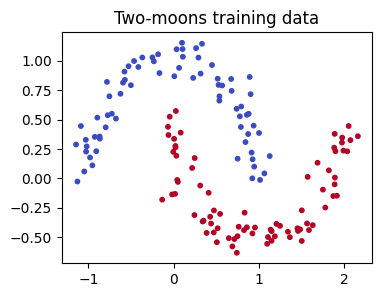

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
import pennylane.numpy as pnp

from quantumuq import ShotBootstrap, wrap_qnode, ece, nll
from quantumuq.datasets.toy import make_moons

rng = np.random.default_rng(0)
dataset = make_moons(n_samples=200, noise=0.1, random_state=0)
X, y = dataset.X, dataset.y

# Train / test split
perm = rng.permutation(len(X))
train_idx, test_idx = perm[:150], perm[150:]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

plt.figure(figsize=(4, 3))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", s=10)
plt.title("Two-moons training data")
plt.show()

In [2]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

n_layers = 2
weights_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
params = 0.1 * pnp.array(rng.standard_normal(weights_shape))

@qml.qnode(dev)
def vqc(features, params):
    qml.AngleEmbedding(features, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))

# Map 4 outcome probs (|00>,|01>,|10>,|11>) to 2 classes: class0 = P(0*), class1 = P(1*)
def probs_4_to_2(probs):
    p = pnp.array(probs)
    if p.ndim == 1:
        return pnp.array([p[0] + p[1], p[2] + p[3]])
    return pnp.stack([p[:, 0] + p[:, 1], p[:, 2] + p[:, 3]], axis=-1)

def loss(params):
    logits = []
    for x in X_train:
        p = vqc(x, params)
        logits.append(p)
    probs = pnp.stack(logits)  # (150, 4)
    probs = probs_4_to_2(probs)  # (150, 2)
    y_one_hot = pnp.eye(2)[y_train]
    probs = pnp.clip(probs, 1e-12, 1.0)
    return -pnp.mean(pnp.sum(y_one_hot * pnp.log(probs), axis=1))

grad_fn = qml.grad(loss, argnum=0)

for epoch in range(20):
    g = grad_fn(params)
    params = params - 0.2 * g
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: loss={loss(params):.3f}")

Epoch 5: loss=0.750
Epoch 10: loss=0.615
Epoch 15: loss=0.588
Epoch 20: loss=0.574


Test NLL: 0.557, ECE: 0.246


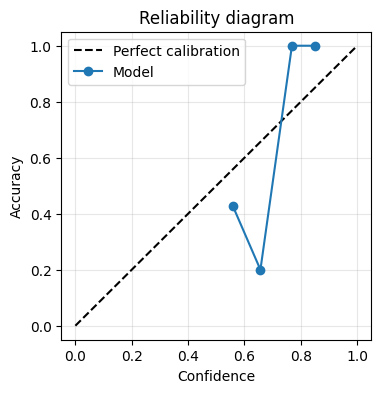

In [3]:
# Wrap QNode as a QuantumUQ predictor (same 4->2 mapping for class probs)
predictor = wrap_qnode(
    vqc, task="classification", n_classes=2, params=params, postprocess=probs_4_to_2
)
uq = ShotBootstrap(n_samples=16, shots=1000, seed=0)
uq_model = predictor.with_uq(uq)

dist = uq_model.predict_dist(X_test)
probs = dist.mean
y_pred = probs.argmax(axis=1)

test_nll = nll(y_test, probs)
test_ece = ece(y_test, probs, n_bins=10)
print(f"Test NLL: {test_nll:.3f}, ECE: {test_ece:.3f}")

# Reliability diagram
confidences = probs.max(axis=1)
predictions = probs.argmax(axis=1)
accuracies = (predictions == y_test).astype(float)

n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_acc = []
bin_conf = []

for i in range(n_bins):
    m = (confidences >= bins[i]) & (confidences < bins[i+1])
    if not np.any(m):
        bin_acc.append(np.nan)
        bin_conf.append(np.nan)
    else:
        bin_acc.append(accuracies[m].mean())
        bin_conf.append(confidences[m].mean())

plt.figure(figsize=(4, 4))
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.plot(bin_conf, bin_acc, "o-", label="Model")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability diagram")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()